**Task 1 : Set up colab gpu runtime environment**

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

^C
  Cloning https://github.com/albumentations-team/albumentations to c:\users\hp\appdata\local\temp\pip-req-build-faxl3i8j


  ERROR: Error [WinError 2] Le fichier spécifié est introuvable while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


     ---------------------------------------- 0.0/44.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/44.9 MB 1.3 MB/s eta 0:00:36
     --------------------------------------- 0.1/44.9 MB 544.7 kB/s eta 0:01:23
     --------------------------------------- 0.1/44.9 MB 655.4 kB/s eta 0:01:09
     --------------------------------------- 0.1/44.9 MB 599.1 kB/s eta 0:01:15
     --------------------------------------- 0.2/44.9 MB 655.4 kB/s eta 0:01:09
     --------------------------------------- 0.2/44.9 MB 655.9 kB/s eta 0:01:09
     --------------------------------------- 0.2/44.9 MB 655.6 kB/s eta 0:01:09
     --------------------------------------- 0.2/44.9 MB 655.6 kB/s eta 0:01:09
     --------------------------------------- 0.3/44.9 MB 607.9 kB/s eta 0:01:14
     --------------------------------------- 0.3/44.9 MB 612.3 kB/s eta 0:01:13
     --------------------------------------- 0.3/44.9 MB 599.0 kB/s eta 0:01:15
     --------------------------------------- 0.4/

**Download Subset Dataset**

In [7]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Some Common Imports**

In [9]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [10]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

**Task : 2 Setup Configurations**

In [11]:
CSV_FILE ='/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE= 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'




In [12]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [16]:
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [ ]:
idx=15

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image= cv2.imread(image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255

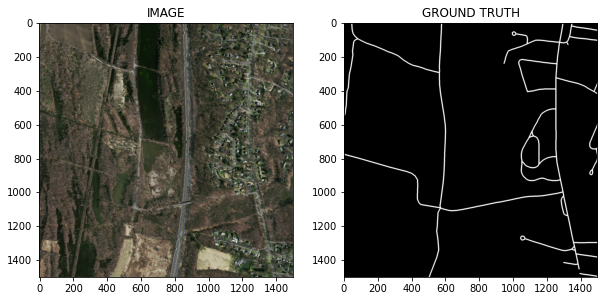

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df)

159

**Task 3 : Augmentation Functions**

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from albumentations.augmentations.geometric.resize import Resize
def get_train_augs() :
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p= 0.5),
        A.VerticalFlip(p=0.5)
    ])
def get_valid_augs() :
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

**Task 4 : Create Custom Dataset**

In [ ]:
from torch.utils.data import Dataset 

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image= cv2.imread(image_path)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #(h,w,c)

    mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
    mask= np.expand_dims(mask, axis = -1)# (h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data['image'] #(h,w,c)
      mask = data['mask']

    image = np.transpose(image, (2,  0, 1 )).astype(np.float32) #(c,h,w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c,h,w)

    image= torch.Tensor(image) / 255.0
    mask= torch.round(torch.Tensor(mask) / 255.0)

    return image,mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
  print(f'Size of trainset : {len(trainset)}')
  print(f'Size of validset : {len(validset)}')


Size of trainset : 159
Size of validset : 40


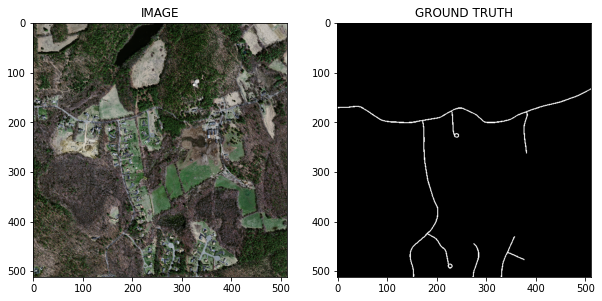

In [ ]:
idx =3
image, mask = trainset[idx]

helper.show_image(image, mask)

**Task 5 : Load dataset into batches**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
    print(f'Total number of batches in trainloader : {len(trainloader)}')
    print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;


One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


**Task 6 : Create Segmentation Model**

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes =1,
        activation= None
    )

  def forward(self, images, masks= None):
      logits= self.backbone(images)

      if masks != None :
        return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

      return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

**Task 7 : Create Train and Validation Function**

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train()# turn ON droout, batchnorm, etc

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks= masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss, = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval()# turn OFF dropout, batchnorm, etc

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks= masks.to(DEVICE)
      logits, loss, = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

**Task 8 : Train the model**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_loss= np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss= eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED-MODEL")
    best_loss= valid_loss
  
  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.0442700773477553 Valid Loss : 0.9447684168815613


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.7486202418804169 Valid Loss : 0.8604871749877929


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.6886265277862549 Valid Loss : 0.7501819372177124


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.6617285311222076 Valid Loss : 0.706497311592102


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.6411047339439392 Valid Loss : 0.6911134719848633


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 6 Train Loss : 0.6421153217554092 Valid Loss : 0.7406307578086853


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 7 Train Loss : 0.6398032665252685 Valid Loss : 0.7840994954109192


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 8 Train Loss : 0.6271339058876038 Valid Loss : 0.7254843950271607


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch : 9 Train Loss : 0.6063652187585831 Valid Loss : 0.6766809701919556


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch : 10 Train Loss : 0.6163414627313614 Valid Loss : 0.6326324820518494


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 11 Train Loss : 0.5974311426281929 Valid Loss : 0.6551108121871948


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 12 Train Loss : 0.6037723124027252 Valid Loss : 0.6677221894264221


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


SAVED-MODEL
Epoch : 13 Train Loss : 0.5924201309680939 Valid Loss : 0.6225905418395996


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 14 Train Loss : 0.5765769213438035 Valid Loss : 0.6685448884963989


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 15 Train Loss : 0.5874165952205658 Valid Loss : 0.6560899019241333


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 16 Train Loss : 0.5820009738206864 Valid Loss : 0.6244773745536805


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch : 17 Train Loss : 0.579121333360672 Valid Loss : 0.6935434103012085


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch : 18 Train Loss : 0.572869548201561 Valid Loss : 0.6631904244422913


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 19 Train Loss : 0.5689894765615463 Valid Loss : 0.6523042798042298


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED-MODEL
Epoch : 20 Train Loss : 0.5598522603511811 Valid Loss : 0.5912075996398926


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch : 21 Train Loss : 0.5623939603567123 Valid Loss : 0.6148247480392456


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch : 22 Train Loss : 0.5615734234452248 Valid Loss : 0.6810227990150451


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 23 Train Loss : 0.575963006913662 Valid Loss : 0.6509752869606018


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 24 Train Loss : 0.5693167671561241 Valid Loss : 0.6125316977500915


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

Epoch : 25 Train Loss : 0.5572493448853493 Valid Loss : 0.607762336730957


**Task 9 : Inference**

In [ ]:
idx= 30

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w) --  (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

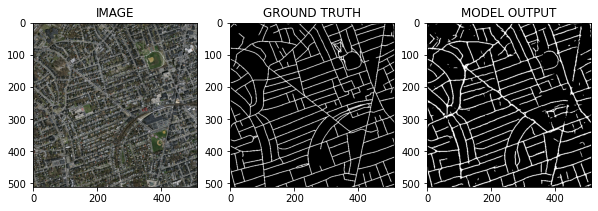

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))